In [1]:
from tqdm import tqdm_notebook

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import mne

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from pylab import rcParams


In [7]:
name = "00010418_s012_t002"
# path = "/tf/epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/00010418_s012_t002.edf"

path = "/tf/epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/00010418_s012_t001.edf"

In [8]:
header = ["file", "start", "end", "label", "confidence"]
train_df = pd.read_csv("../_DOCS/ref_train.txt", sep=" ", names=header)

In [9]:
edf = mne.io.read_raw_edf(path, preload=True)

Extracting EDF parameters from /tf/epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/00010418_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 586999  =      0.000 ...  2347.996 secs...


In [10]:
edf.filter(2, 60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 413 samples (1.652 sec)



<RawEDF | 00010418_s012_t001.edf, 30 x 587000 (2348.0 s), ~134.4 MB, data loaded>

# Full picture of a seizure

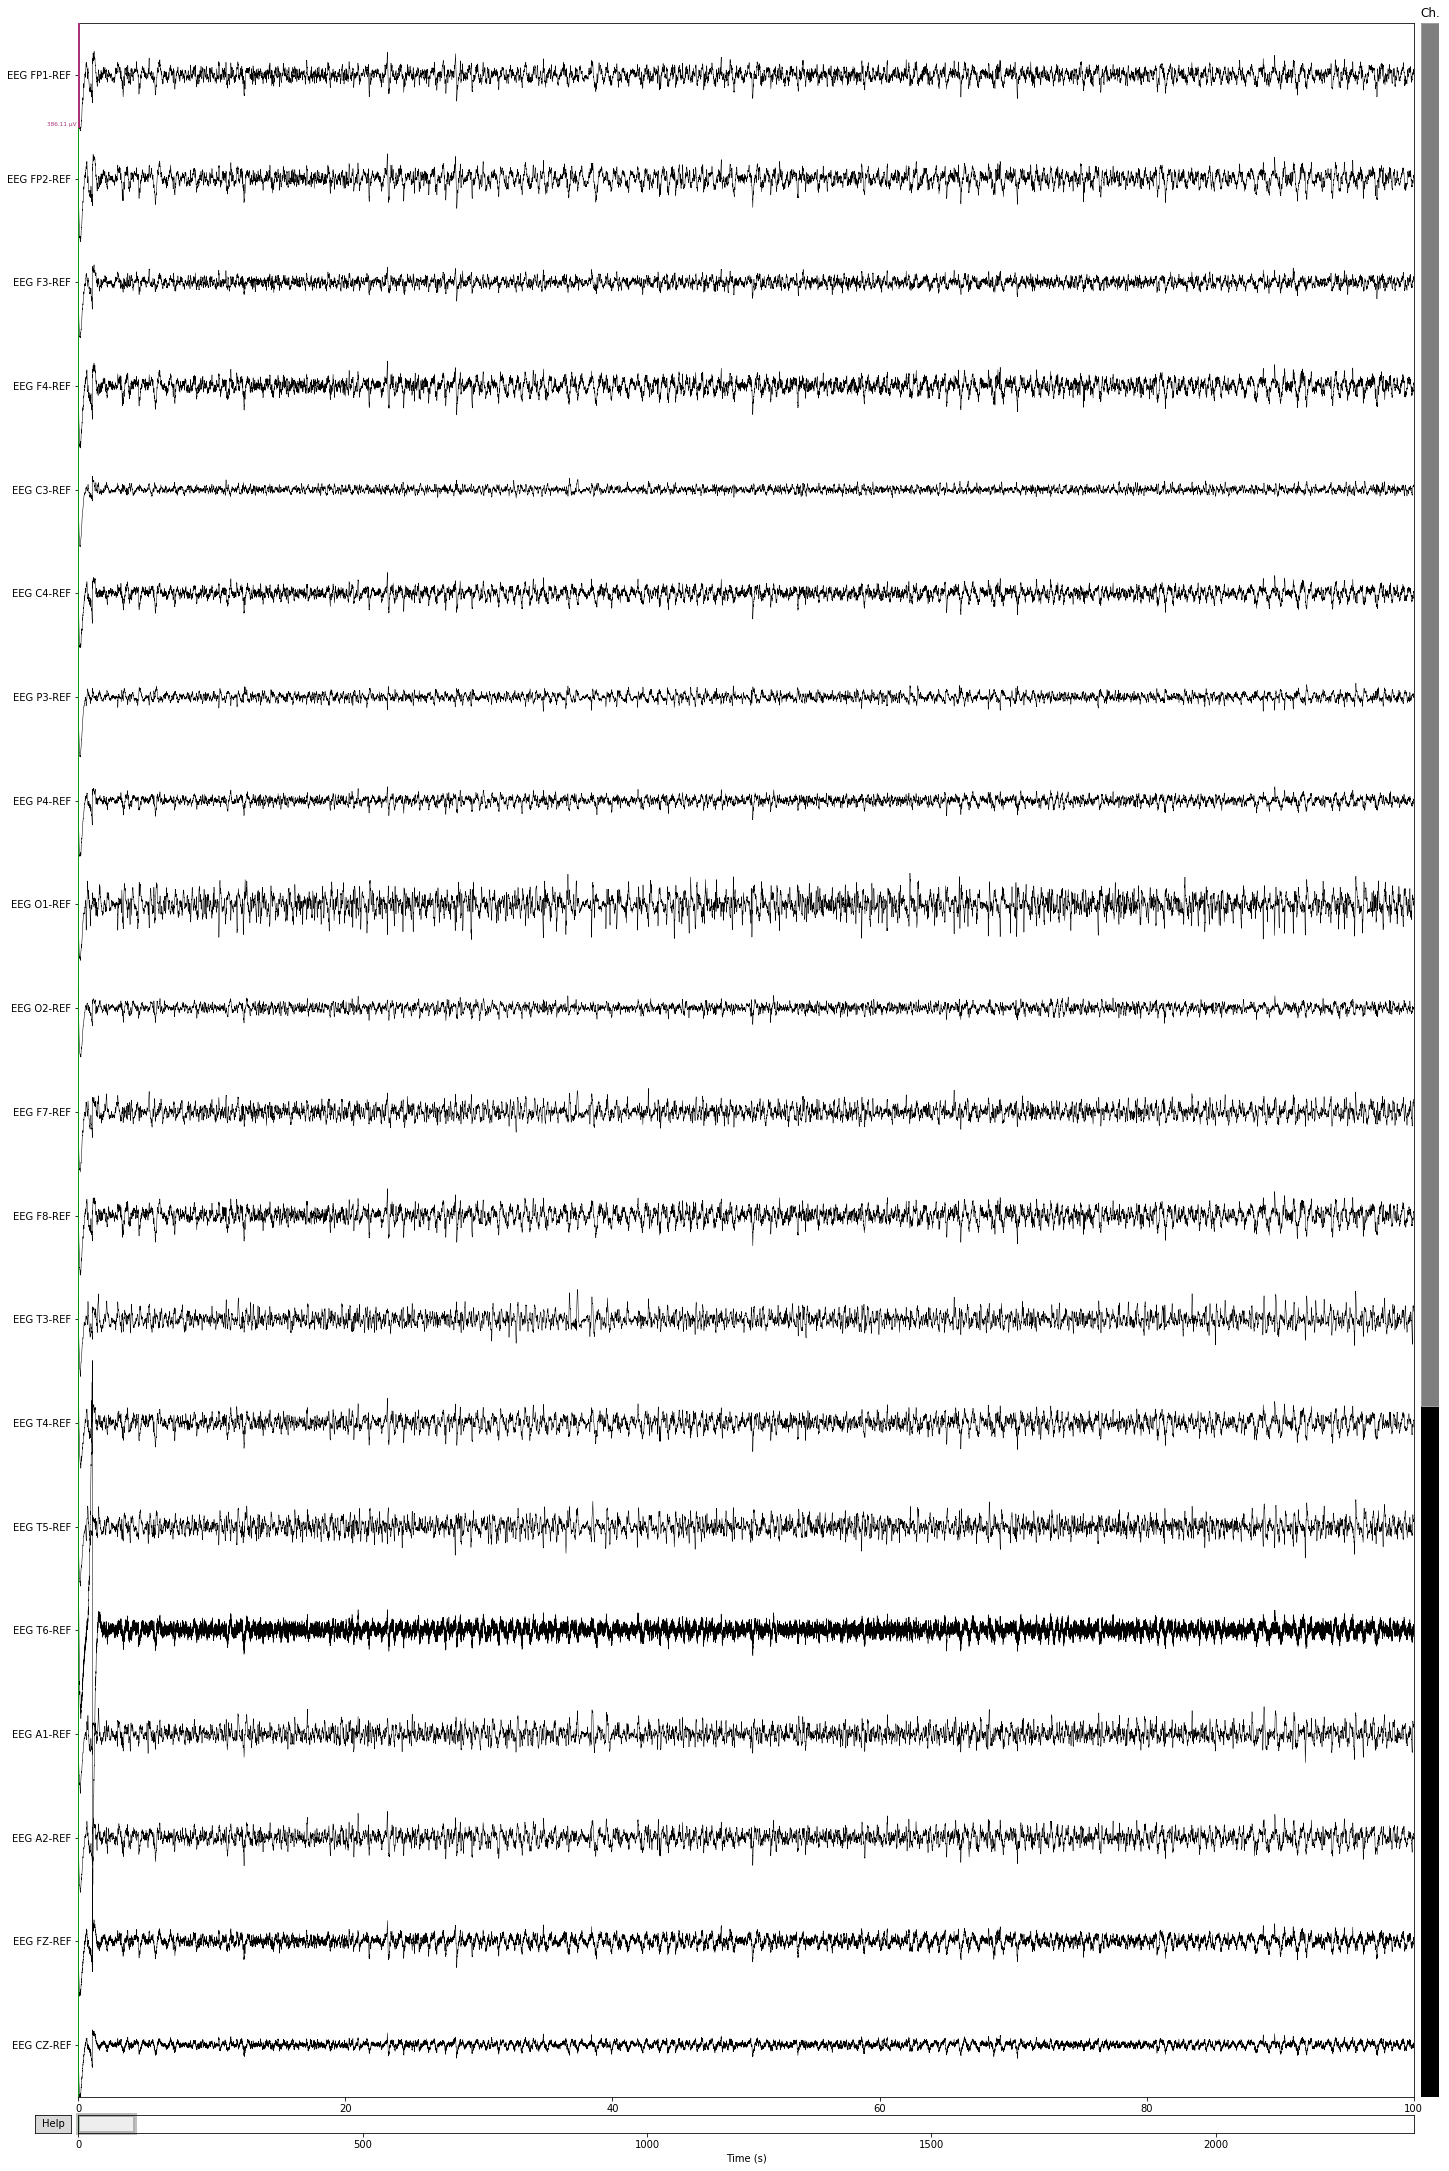

In [11]:
rcParams['figure.figsize'] = 20, 30
mne.viz.plot_raw(
    edf, 
    start=0, 
    duration=100, 
    show=False, 
    scalings=np.percentile(np.abs(edf[0:10000][0]), 99.99)
)
plt.show()

# Electrodes positions

# Montage visualization

In [12]:
CHANNELS_MAPPING = [
    ("EEG FP1-REF", "EEG F7-REF"), 
    ("EEG F7-REF", "EEG T3-REF"), 
    ("EEG T3-REF", "EEG T5-REF"), 
    ("EEG T5-REF", "EEG O1-REF"), 
    ("EEG FP2-REF", "EEG F8-REF"), 
    ("EEG F8-REF", "EEG T4-REF"), 
    ("EEG T4-REF", "EEG T6-REF"), 
    ("EEG T6-REF", "EEG O2-REF"), 
    ("EEG A1-REF", "EEG T3-REF"), 
    ("EEG T3-REF", "EEG C3-REF"), 
    ("EEG C3-REF", "EEG CZ-REF"), 
    ("EEG CZ-REF", "EEG C4-REF"), 
    ("EEG C4-REF", "EEG T4-REF"), 
    ("EEG T4-REF", "EEG A2-REF"), 
    ("EEG FP1-REF", "EEG F3-REF"), 
    ("EEG F3-REF", "EEG C3-REF"), 
    ("EEG C3-REF", "EEG P3-REF"), 
    ("EEG P3-REF", "EEG O1-REF"), 
    ("EEG FP2-REF", "EEG F4-REF"), 
    ("EEG F4-REF", "EEG C4-REF"), 
    ("EEG C4-REF", "EEG P4-REF"), 
    ("EEG P4-REF", "EEG O2-REF")
]

CHANNELS_MAPPING_1 = [c[0] for c in CHANNELS_MAPPING]
CHANNELS_MAPPING_2 = [c[1] for c in CHANNELS_MAPPING]

# FFT and DWT - why do they matter

In [13]:
window_size = 250
step_size = window_size // 10

In [14]:
# def get_fourier_transform(data):
#     global window_size, step_size
#     frequencies = []
#     for window in tqdm_notebook(range(0, data.shape[0] - window_size, step_size)):
#         chunk = data[window:window + window_size]
#         frequency_values = np.abs(np.fft.fft(chunk, axis=0))[:window_size // 2]
#         frequencies.append(frequency_values)
#     return np.stack(frequencies)

In [20]:
from scipy.signal import stft
from scipy.fft import fft

In [33]:
def get_fourier_transform(data):
    global window_size, step_size
    return np.abs(stft(
        data, 
        fs=250, 
        window="hann", 
        nperseg=window_size, 
        noverlap=window_size - step_size, 
        return_onesided=True, 
        boundary=None
    )[-1]).T

In [34]:
channels = [c for c in edf.ch_names if "EEG" in c]

In [35]:
edf_picks_1 = [edf.ch_names.index(c) for c in CHANNELS_MAPPING_1]
edf_picks_2 = [edf.ch_names.index(c) for c in CHANNELS_MAPPING_2]

In [36]:
data_1, _ = edf[edf_picks_1, :]
data_2, _ = edf[edf_picks_2, :]

In [37]:
data = data_1 - data_2

In [38]:
data.shape

(22, 587000)

In [39]:
frequencies = get_fourier_transform(data)

In [40]:
frequencies.T.shape

(22, 126, 23471)

In [41]:
frequencies = frequencies#.reshape(frequencies.shape[0], -1)

In [42]:
frequencies.shape

(23471, 126, 22)

In [43]:
# frequencies_one = frequencies

In [44]:
# frequencies_one = frequencies.copy()

In [45]:
events = train_df[train_df["file"] == name]

In [51]:
frequencies_part = np.squeeze(frequencies[:, :, 8])
normalized_frequencies = frequencies_part / frequencies_part.mean(axis=0)
# normalized_frequencies = frequencies

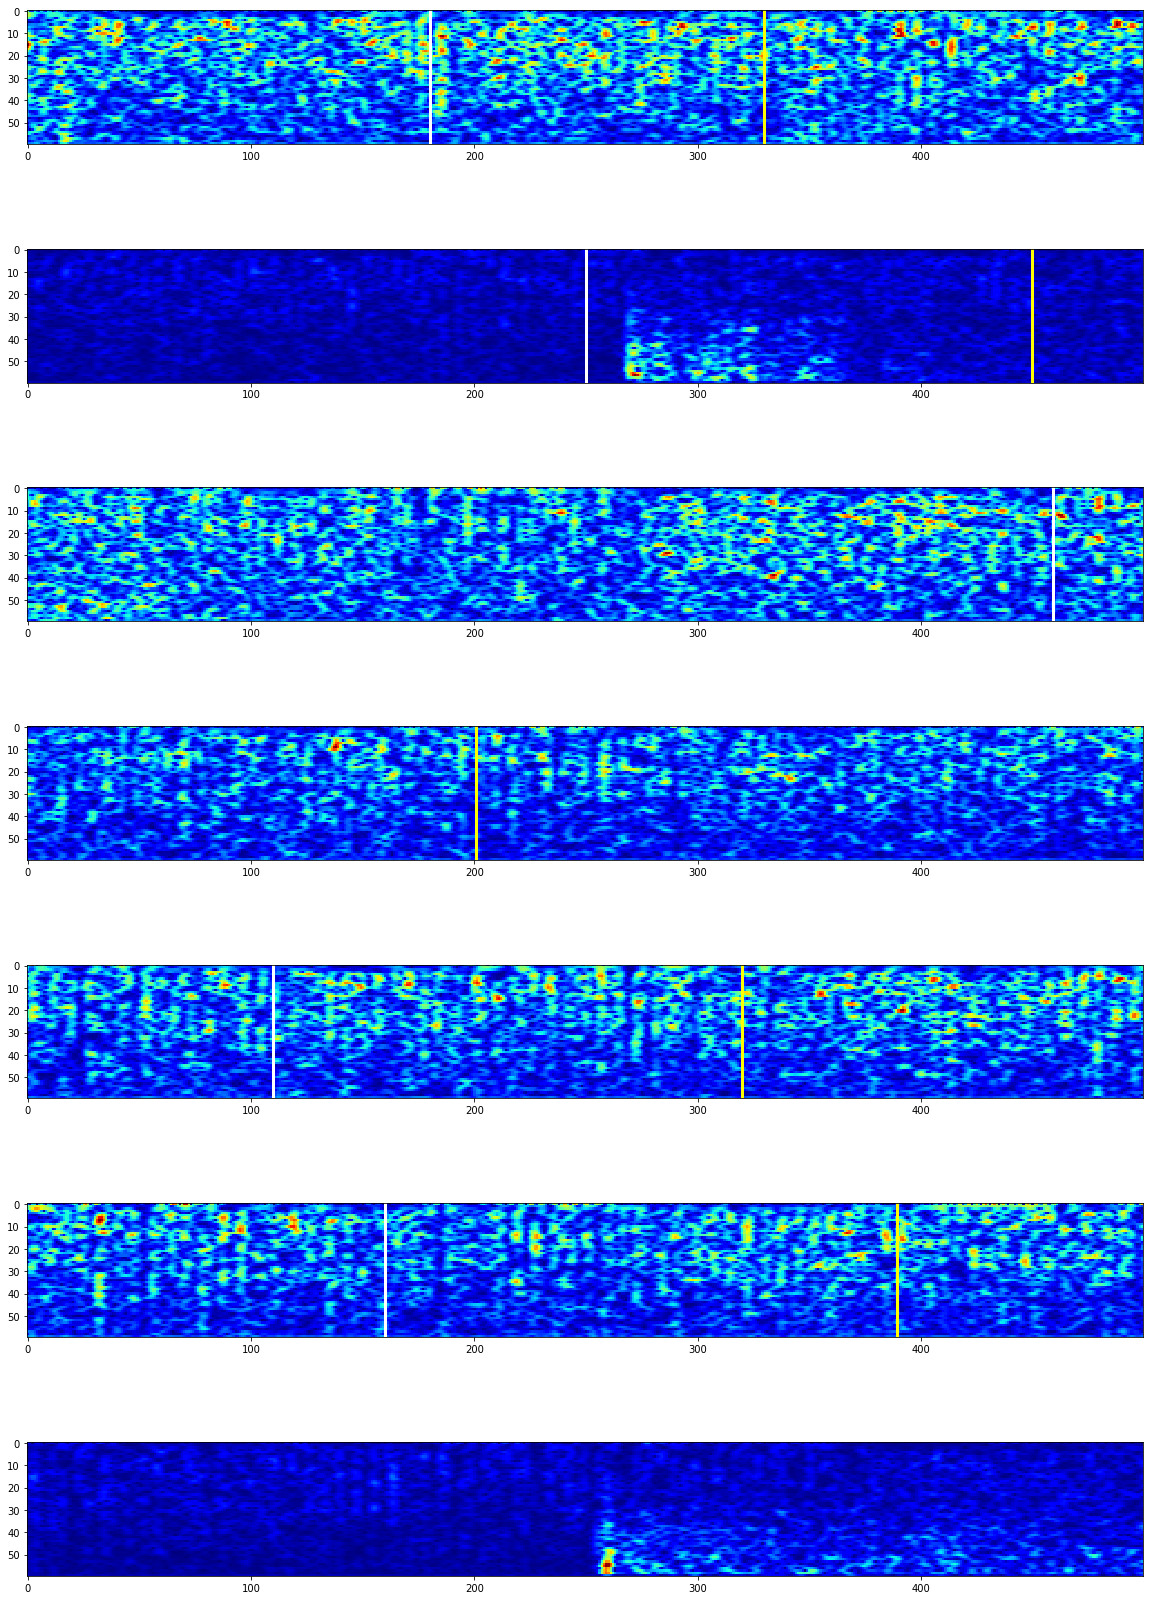

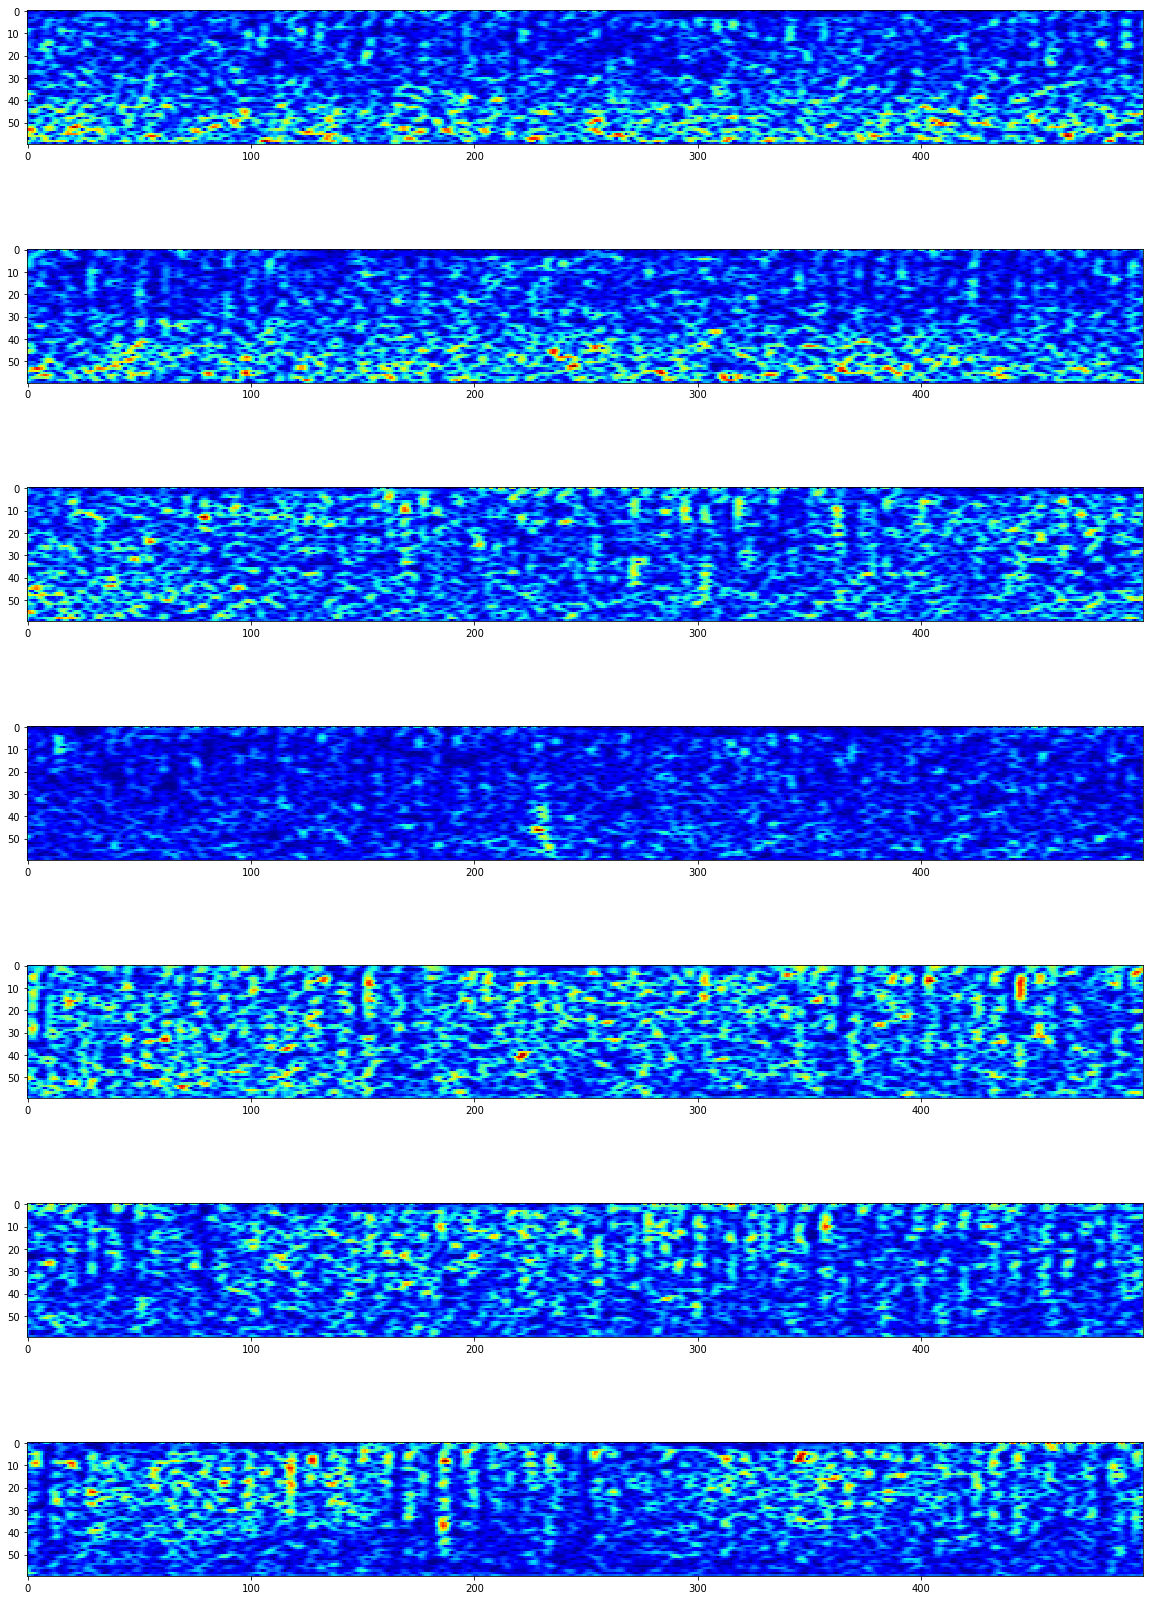

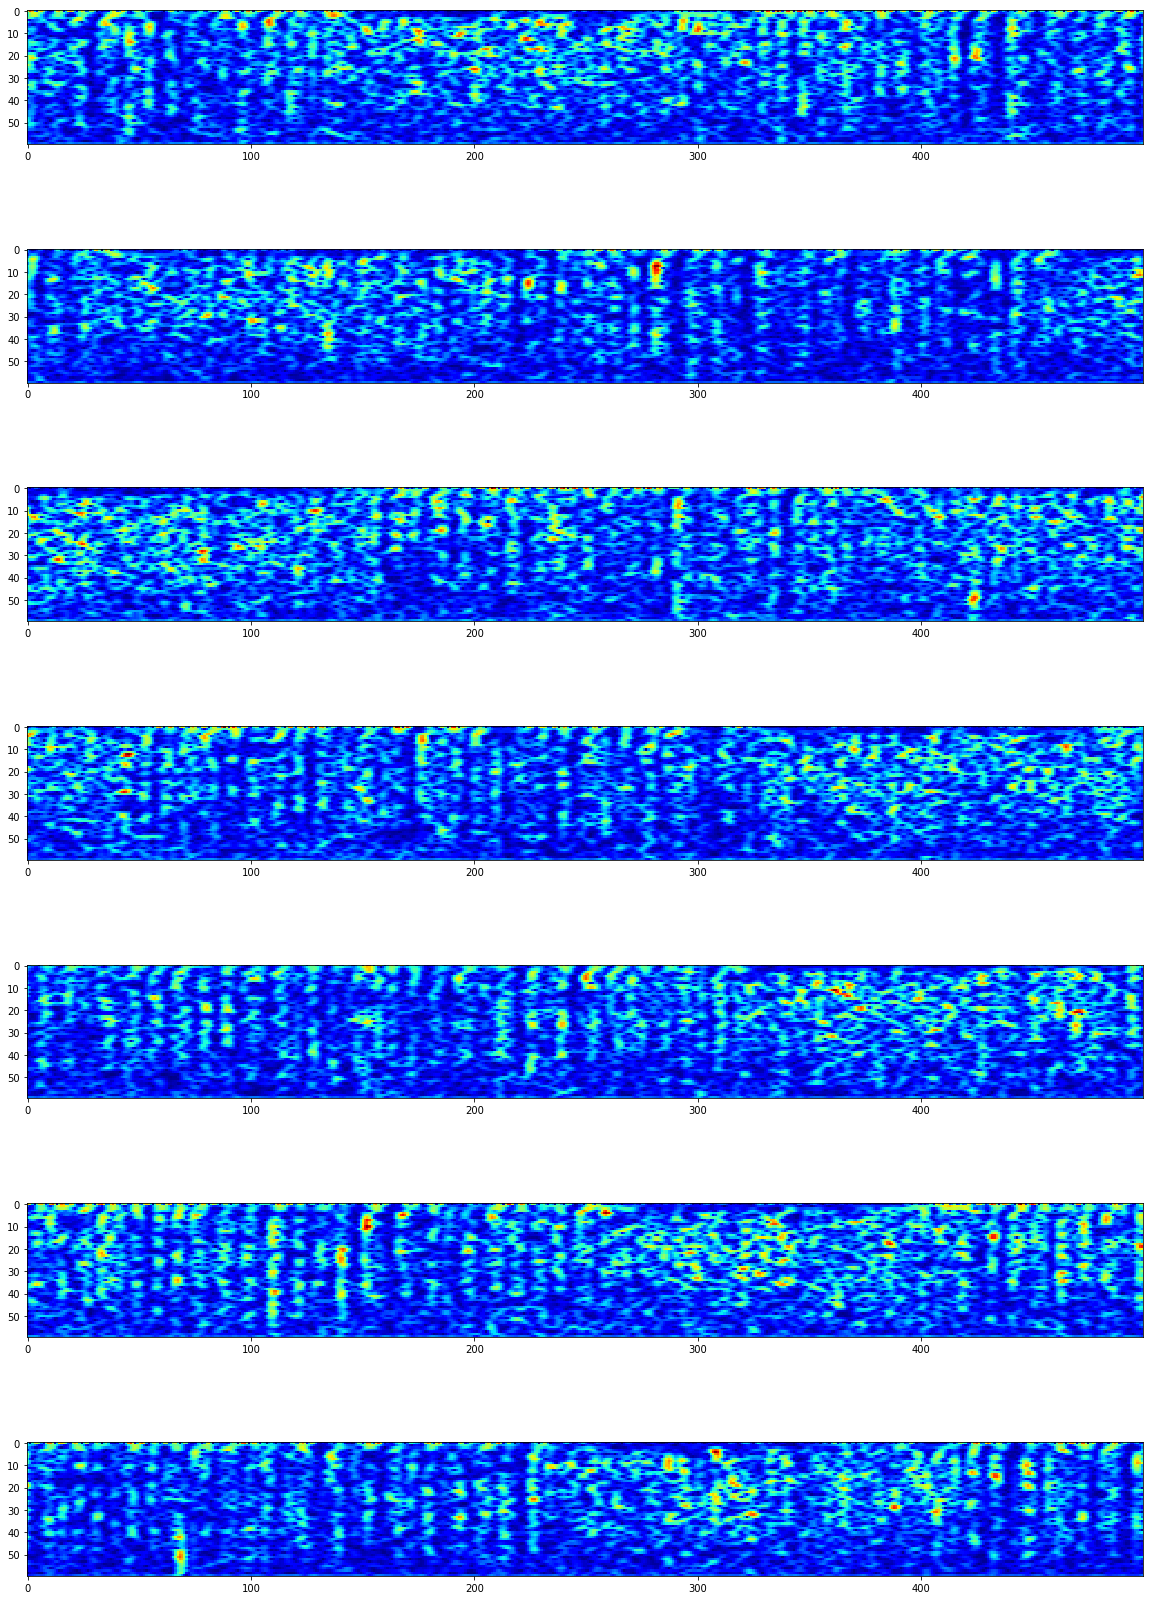

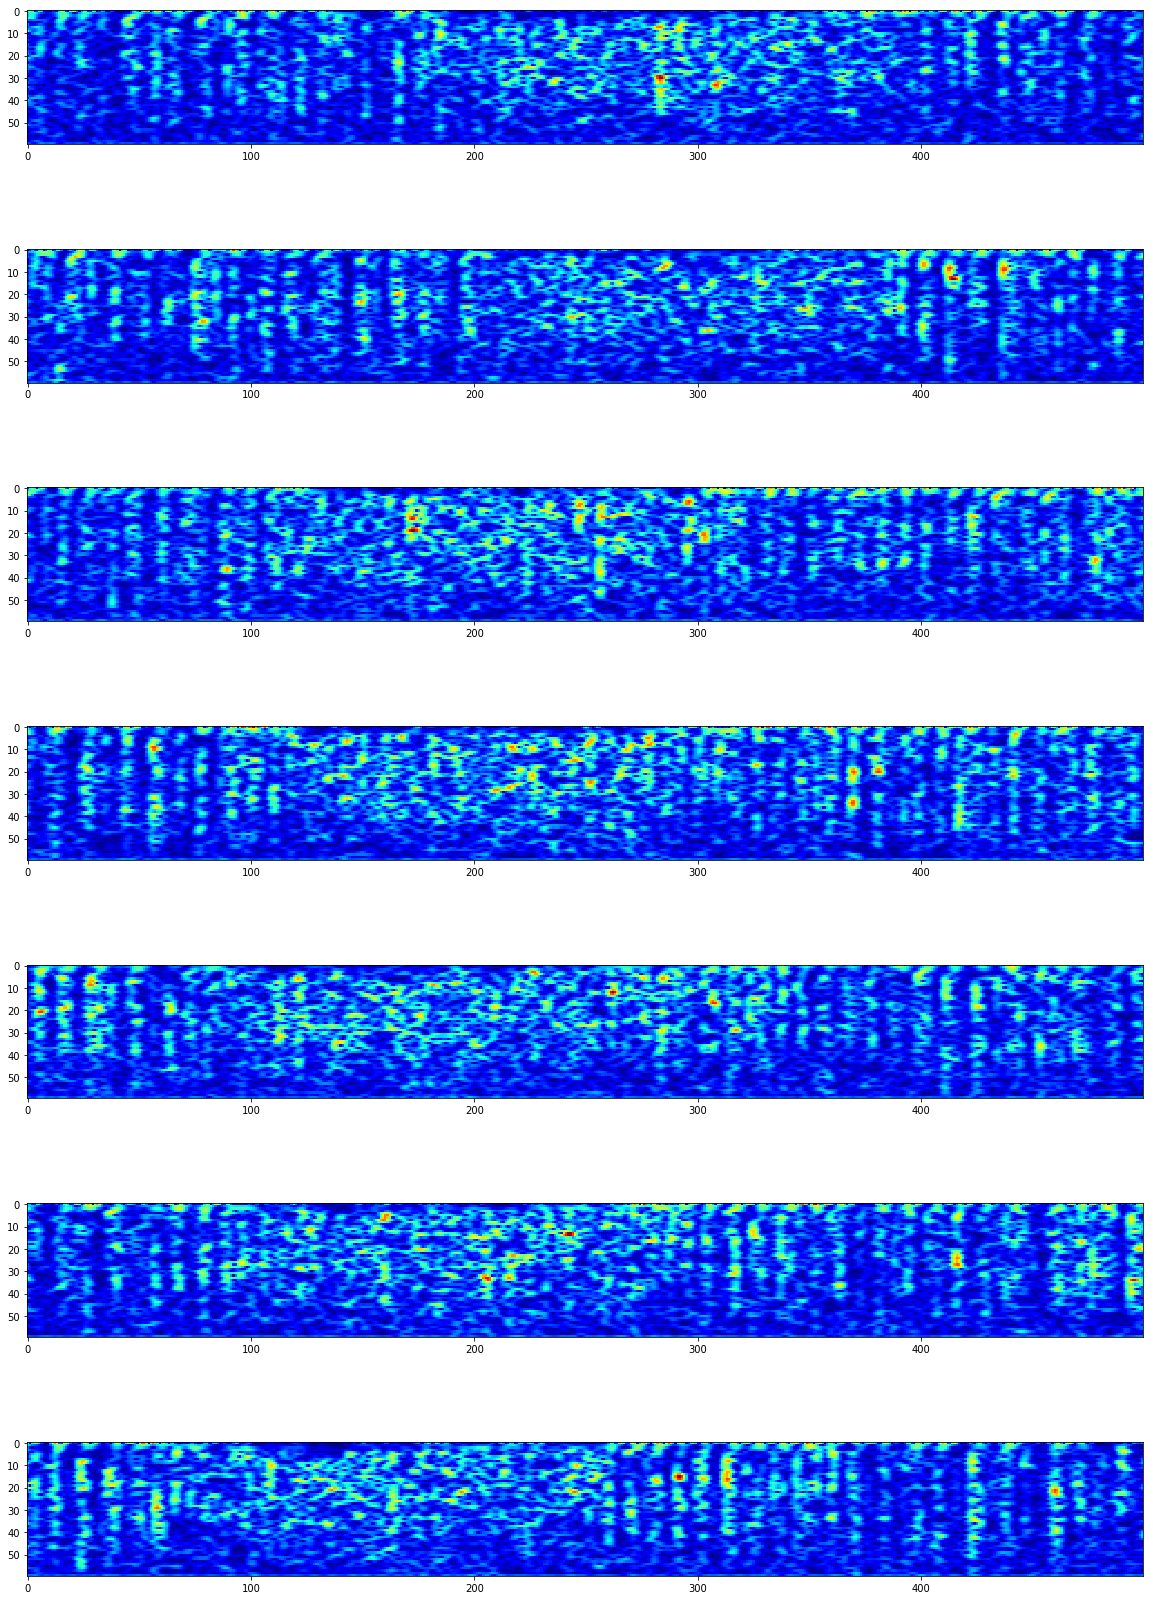

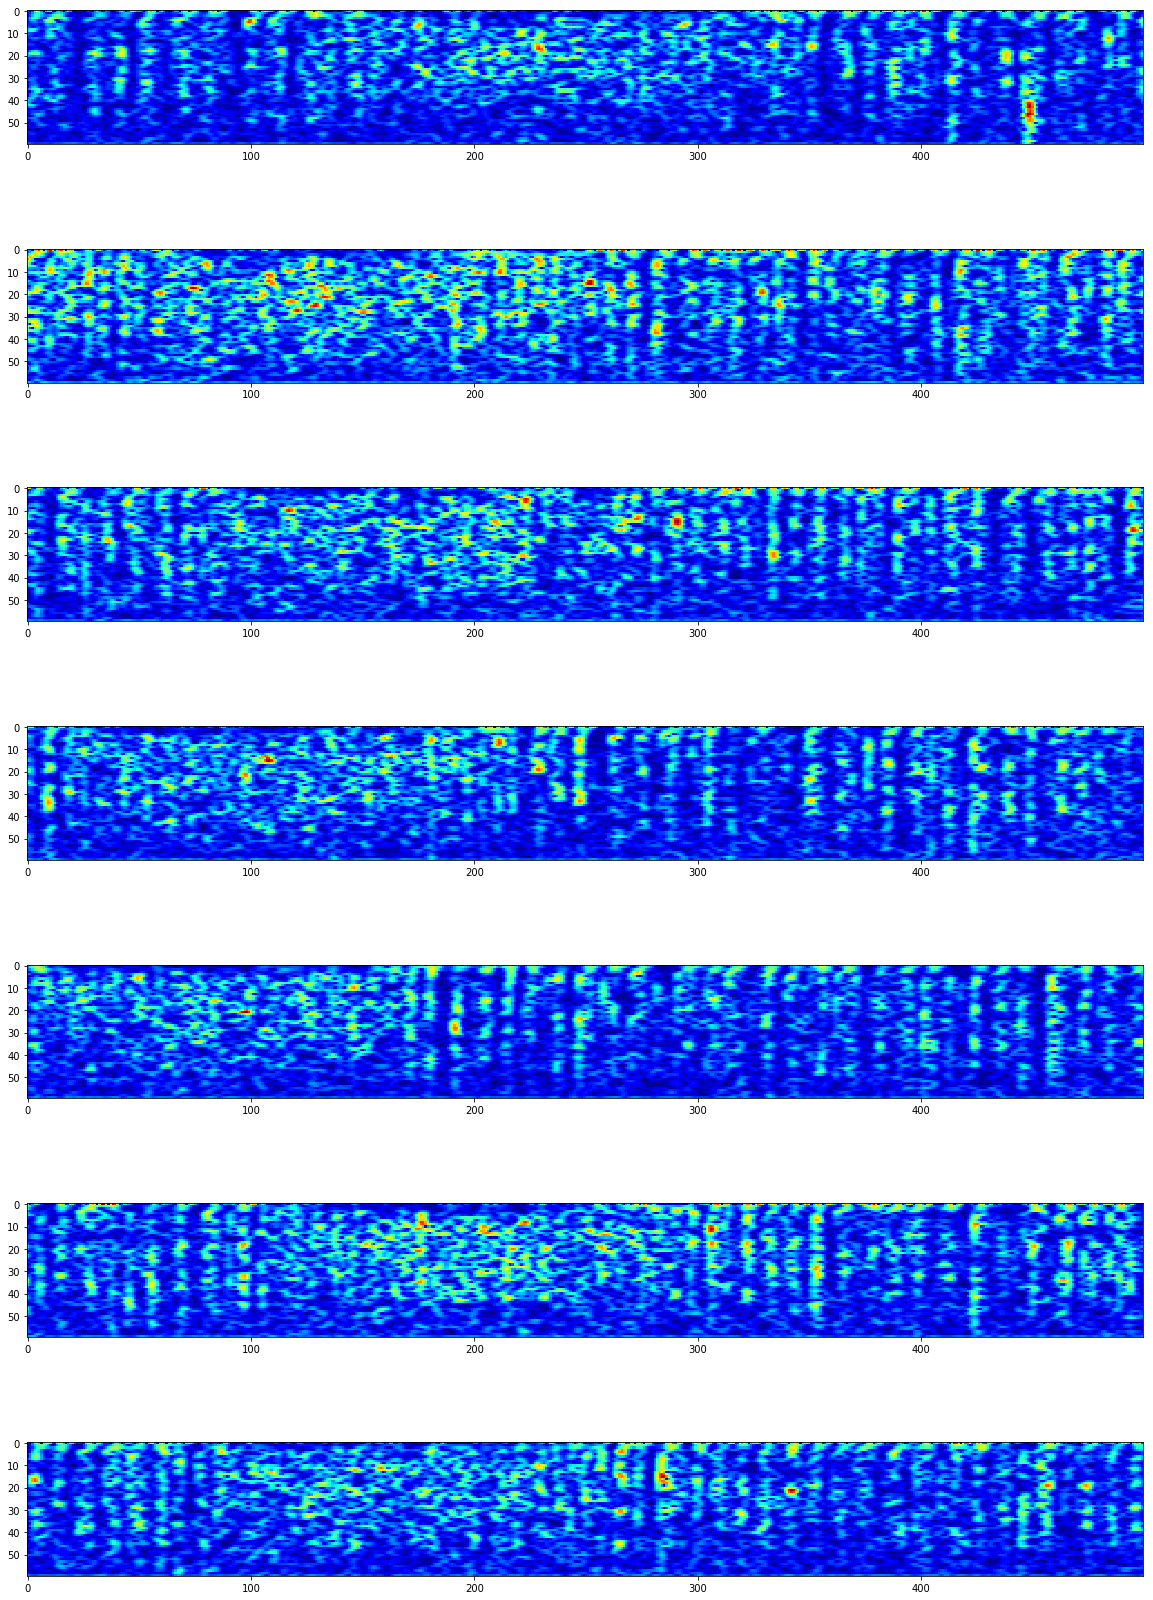

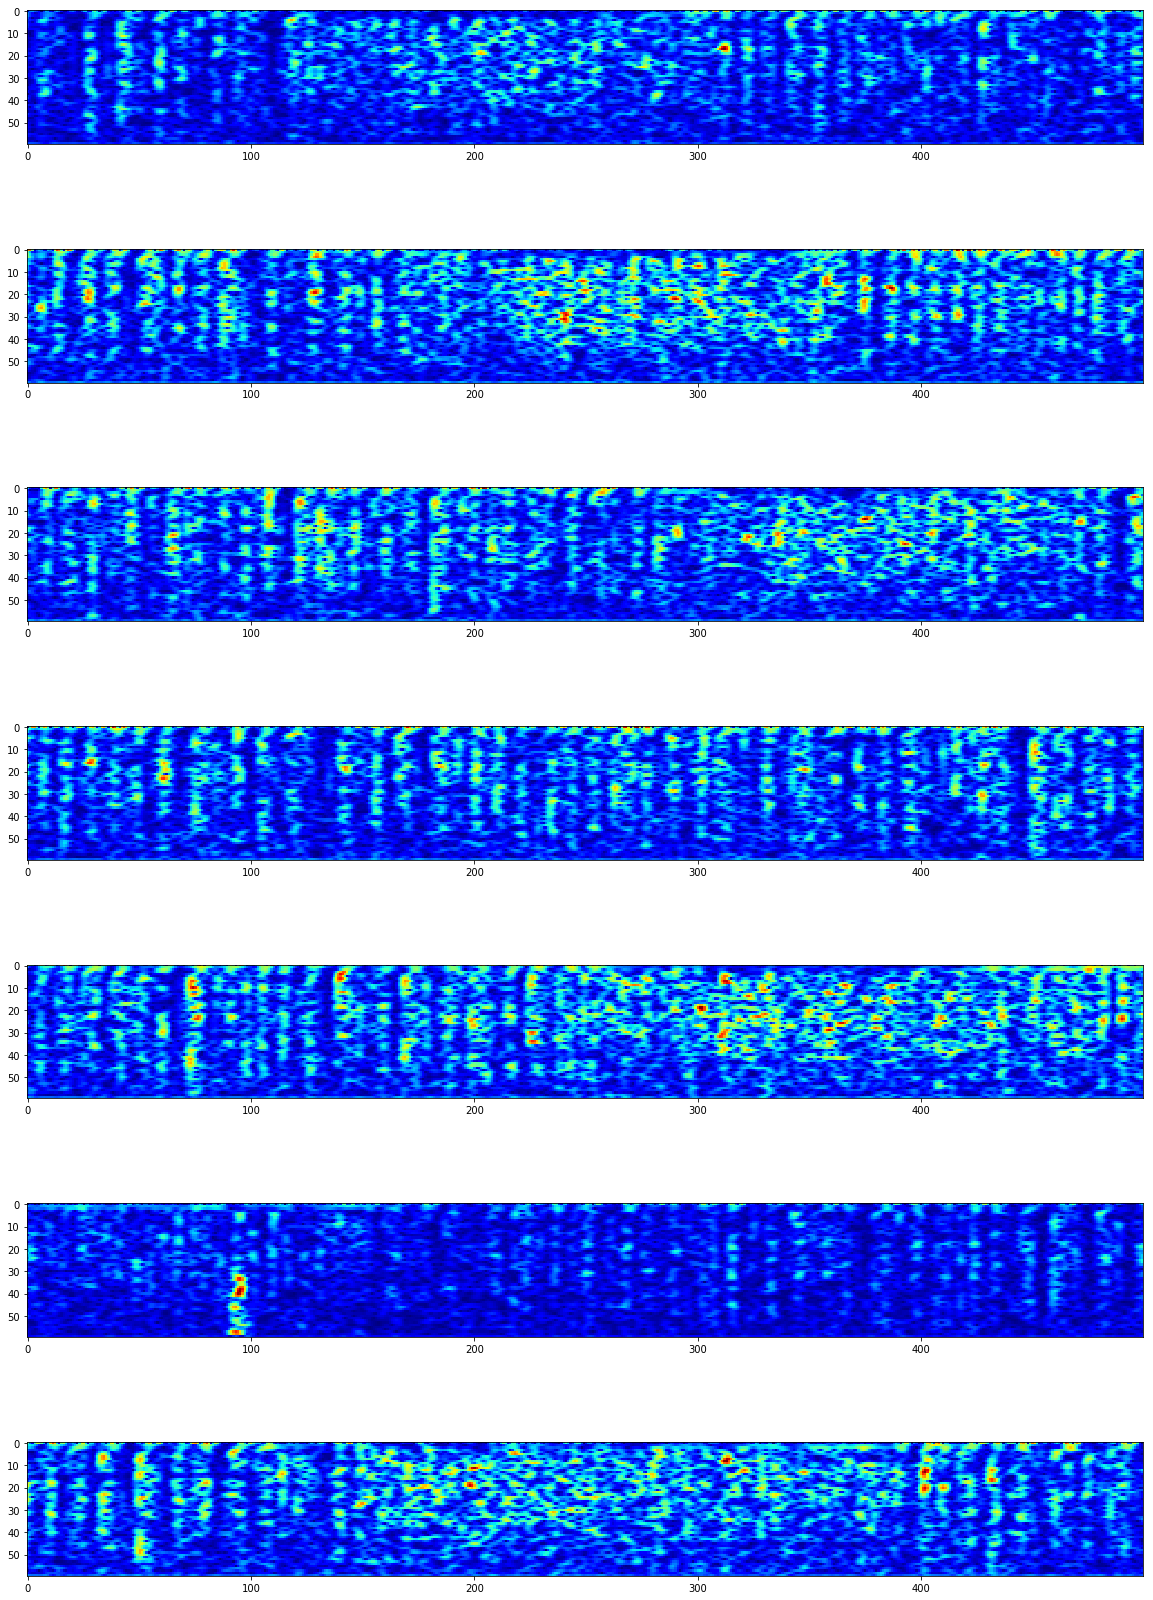

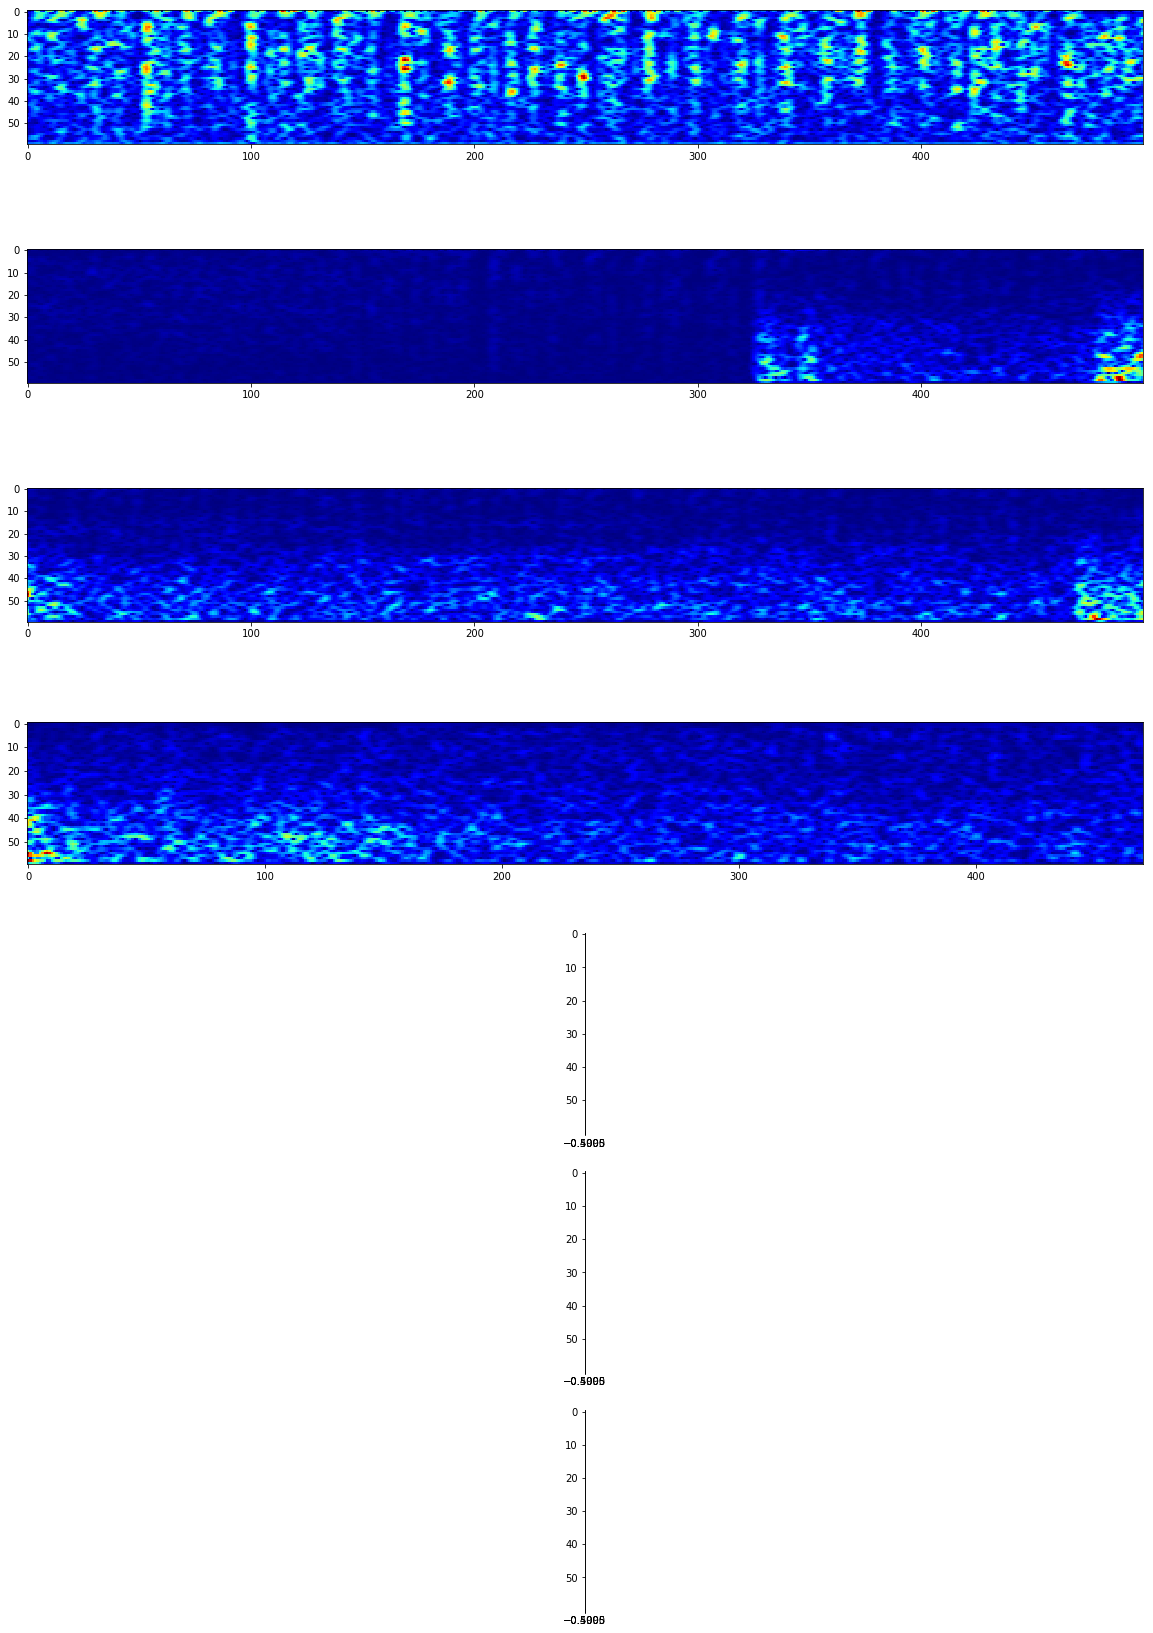

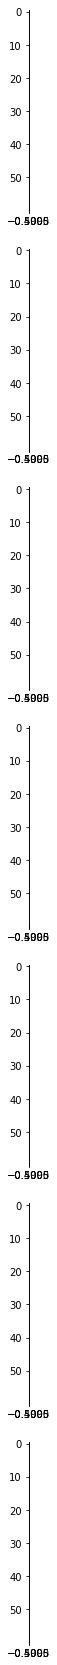

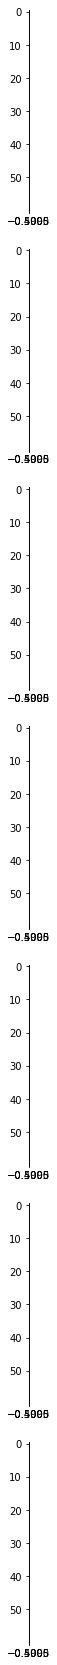

In [ ]:
N = 7
for j in range(10):
    for i in range(1, N + 1):
        start = N * 50 * j + i * 50
        end = N * 50 * j + (i + 1) * 50

        plt.subplot(N * 100 + 10 + i)
        plt.imshow(normalized_frequencies[start * 10:end * 10, 0:60].T, cmap="jet")

        for _, event in events[(events["start"] > start) & (events["start"] < end)].iterrows():
            color = "white"
            if event["label"] == "bckg":
                color = "yellow"
            plt.axvline(event["start"] * 10 - start * 10, color=color, linewidth=3)
    plt.show()

In [54]:
frequencies

(23470, 125)

In [15]:
freqs = np.linspace(0, 60, 0.01)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


# MNE ICA

In [118]:
from mne.preprocessing import ICA

In [119]:
ica = ICA()
ica.fit(edf)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting all PCA components: 30 components
Fitting ICA took 35.0s.


<ICA  |  raw data decomposition, fit (fastica): 587000 samples, 30 components, channels used: "eeg">

In [120]:
ica_eeg = ica.get_sources(edf)

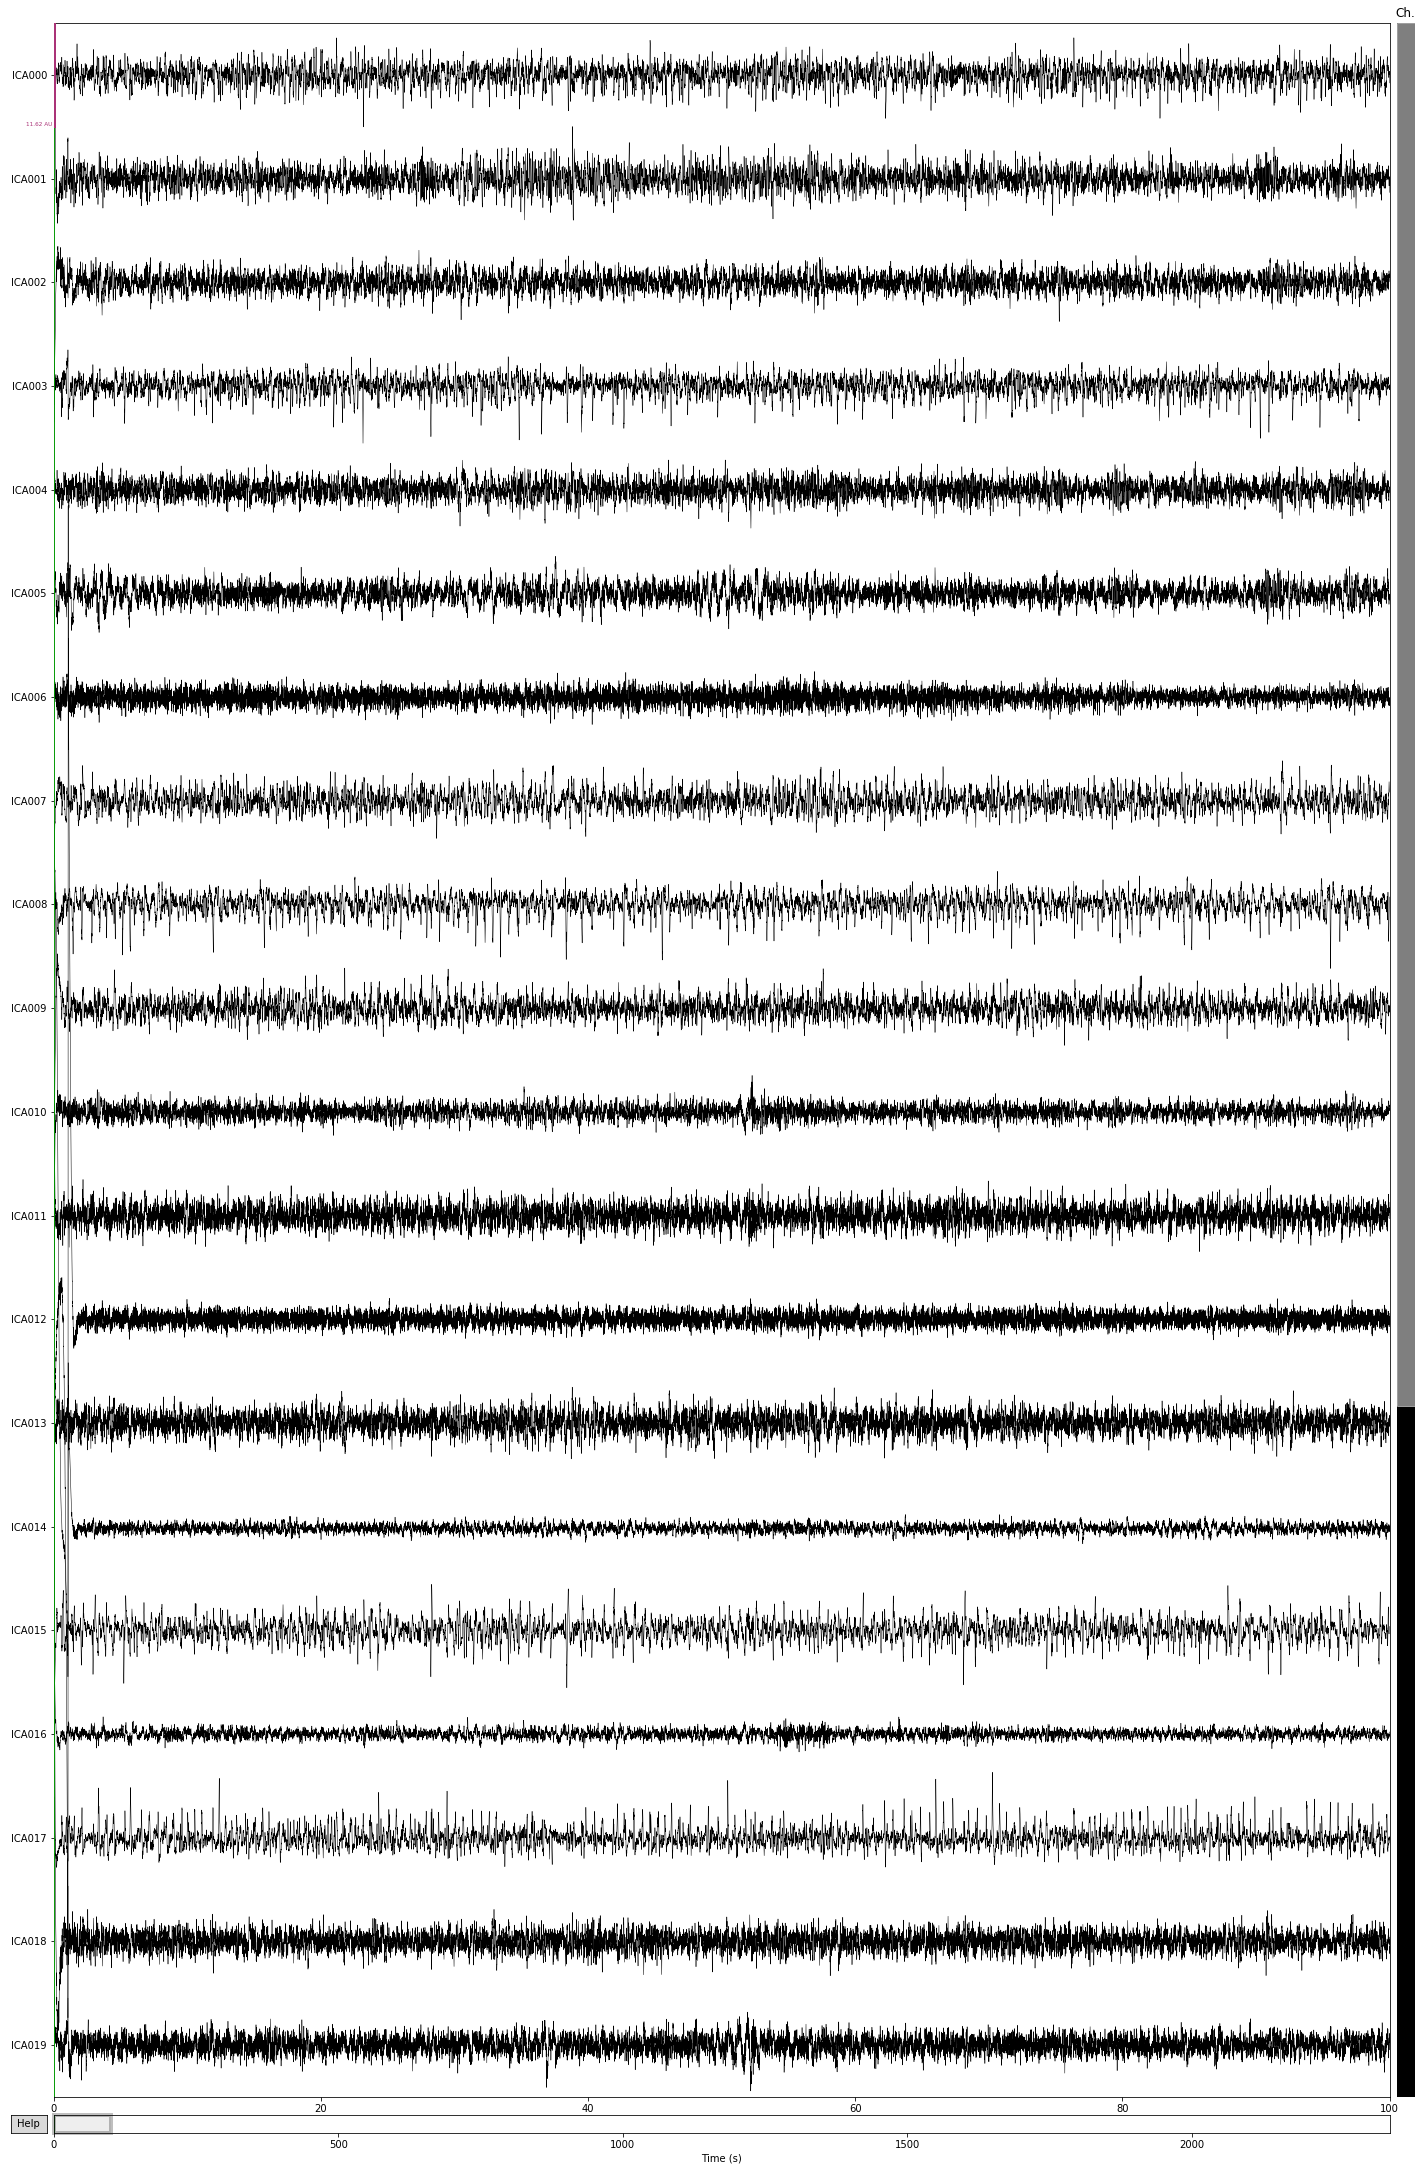

In [122]:
mne.viz.plot_raw(
    ica_eeg, 
    start=0, 
    duration=100, 
    show=False, 
    scalings=np.percentile(np.abs(ica_eeg[0:10000][0]), 99.9)
)
plt.show()